# Pet Image Segmentation Task Using U-Net

* The main aim is to create this project is to identify and detect the object by neural network to pixels.
* This can help mainly in detection for MRI Scans or cancer segmentation or many more medical image segmentation. 
* This project based completely on tensorflow.
* We have used here pix-2-pix method for segmentation.
* Dataset has downloaded form tensorflow datasets.

## Importing packages

In [14]:
# Importing necessary libraries

import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
from IPython.display import clear_output
from matplotlib import pyplot as plt

## Download the data

In [15]:
# Downloading data from Tensorflow API to Sytem.

data, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

* The dataset will be downloaded from tensorflow.
* This will download the pet images as well as masked or segmented images.

## Data Augmentation

* Here, we will be doing some data augmentation to see each positions of an image

In [16]:
# Normalizing or standardizing the data for neural network.

def normalize_the_data(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask


# Loading train and test image dataset for augmentation.

@tf.function
def load_train_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
        
    input_image, input_mask = normalize_the_data(input_image, input_mask)
    
    return input_image, input_mask
    
    
def load_test_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    input_image, input_mask = normalize_the_data(input_image, input_mask)
    
    return input_image, input_mask

## Train-Test Split

In [17]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = data['train'].map(load_train_image, num_parallel_calls=tf.data.AUTOTUNE)
test = data['test'].map(load_test_image)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

## Plotting images with True Mask

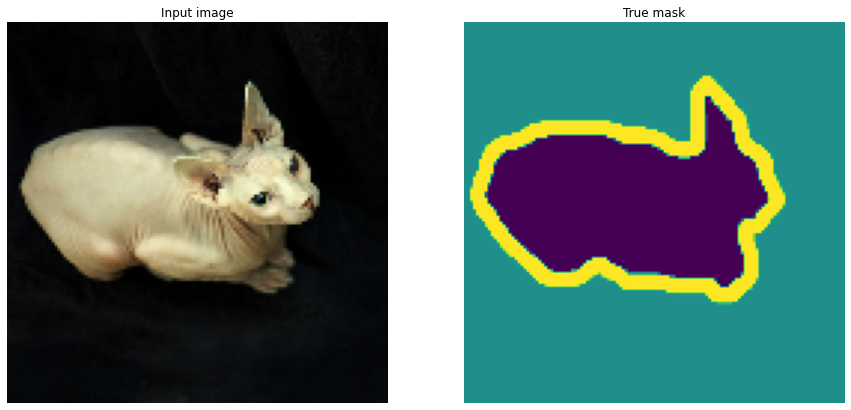

In [18]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    
    title = ['Input image', 'True mask', 'Predicted mask']
    
    for p in range(len(display_list)):
        plt.subplot(1, len(display_list), p+1)
        plt.title(title[p])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[p]))
        plt.axis('off') # On
    plt.show()

# Sample data plotting    
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

## Image Segmentation Model

* In this model we are going to use modified U-Net model.
* In U-Net model we will be have Encoder and Decoder.
* By using this, we will reduce some trainable parameters.
* We will be use a pre-trained model from tensorflow applications which will be our encoder.

In [19]:
OUTPUT_CHANNELS = 3

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top = False)

# Using the activation layers for this layer

layer_names = [
    'block_1_expand_relu',  # 64*64
    'block_3_expand_relu',  # 32*32
    'block_6_expand_relu',  # 16*16
    'block_13_expand_relu', # 8*8
    'block_16_project',     # 4*4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs = base_model_outputs)

down_stack.trainable = False

In [20]:
# The upsampler will be a series of upsampled blocks.

up_stack = [
    pix2pix.upsample(512, 3), # 4x4 -> 8x8
    pix2pix.upsample(256, 3), # 8x8 -> 16x16
    pix2pix.upsample(128, 3), # 16x16 -> 32x32
    pix2pix.upsample(64, 3),  # 32x32 -> 64
]

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    
    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This will be the last layer of this model.    
    last_layer = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same') # 64x64 -> 128
    
    x = last_layer(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

## Training the Model

In [21]:
model = unet_model(OUTPUT_CHANNELS)
model.compile([optimizer='adam', 
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
               metrics = ['accuracy']])

1/1 [==============================] - 0s 28ms/step


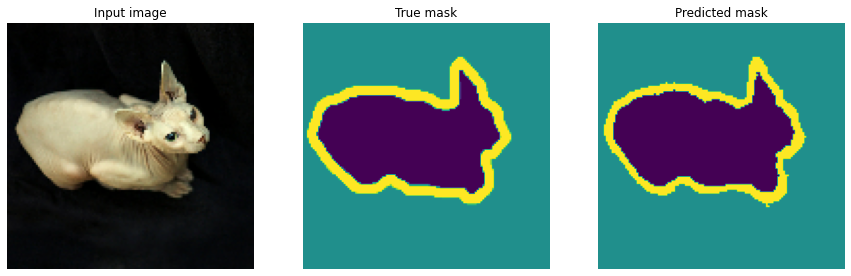

In [27]:
# Checking the predictions

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(data=None, num=1):
    if data:
        for image, mask in data.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    
    else:
        display([sample_image, sample_mask, create_mask(model.predict(sample_image[tf.newaxis, ...]))])
show_predictions()

* Looks good but, we should train the model and see the predictions.

1/1 [==============================] - 0s 19ms/step


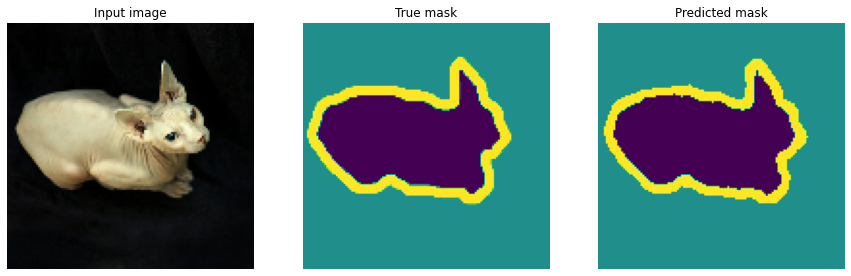


 Sample prediction after epoch 30
57/57 [==============================] - 13s 233ms/step - loss: 0.0605 - accuracy: 0.9672 - val_loss: 0.5359 - val_accuracy: 0.8873


In [30]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print(f'\n Sample prediction after epoch {epoch+1}')
        
EPOCHS = 30
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, validation_data=test_dataset, callbacks=[DisplayCallback()])

* Loss has reduced and Accuracy scored well but, we should have look that how it looks at each epoch.

## Model Performance

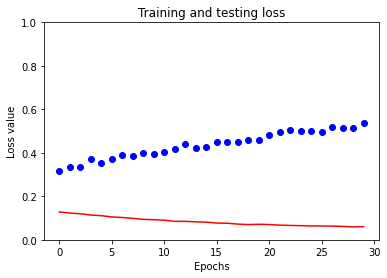

In [31]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'bo', label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.ylim([0, 1])
plt.title('Training and testing loss')
plt.legend()
plt.show()

* Performance looks good but, validations loss goes up at epochs increases.

## Model Predictions

2/2 [==============================] - 0s 354ms/step


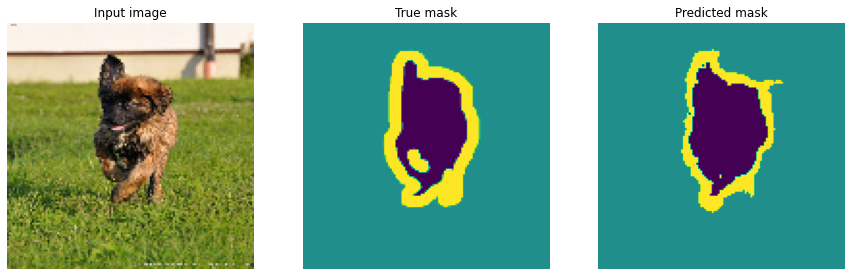

2/2 [==============================] - 0s 52ms/step


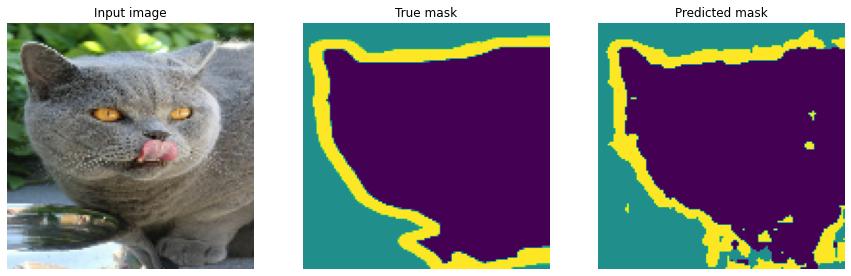

2/2 [==============================] - 0s 75ms/step


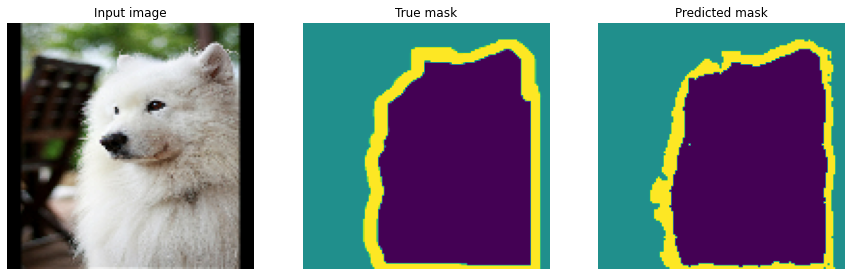

2/2 [==============================] - 0s 49ms/step


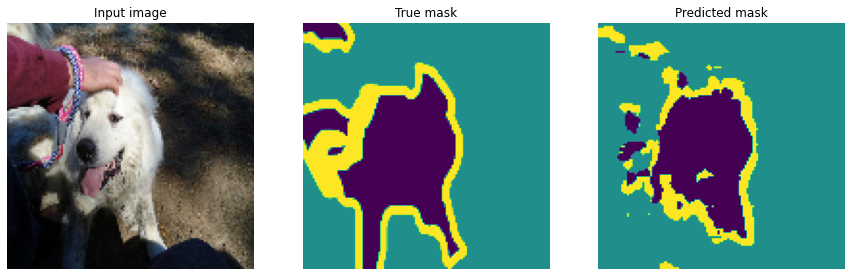

2/2 [==============================] - 0s 55ms/step


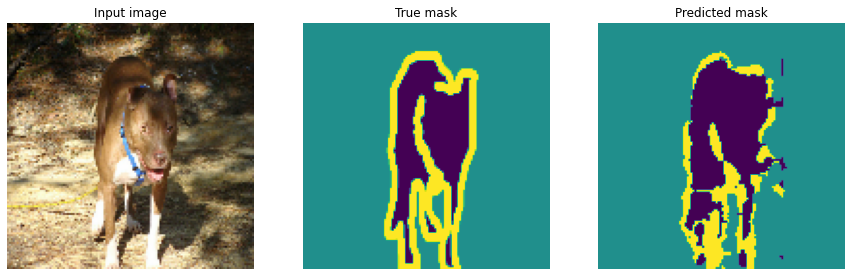

2/2 [==============================] - 0s 67ms/step


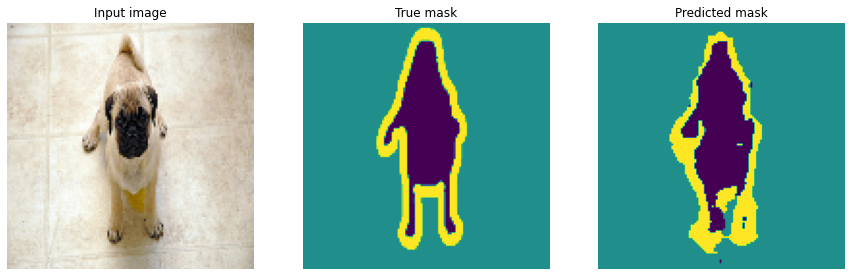

2/2 [==============================] - 0s 66ms/step


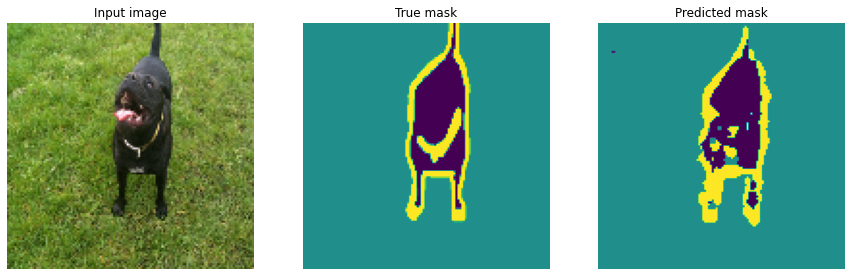

In [34]:
show_predictions(test_dataset, 7)

* Seems good but still needs some improvements and fine tuning.